<div class="alert alert-block alert-info">
<center> <h1> Master in Data Science and Advanced Analytics </h1> </center> <br>
<center> PROJECT 2022/2023 </center>

# Deep Learning - Brain Tumor
*Group Members*:

|      | Student Name                  | Student ID |
|---   |-------------------------------|------------|
| 1    | Mahmoud Ahmed                 | 20221397   |
| 2    | Alex Adrián Santander Morales | 20220658   |
| 3    | Skander Chaabini              | 20221041   |
| 4    | Karim Miladi                  | 20220720   |
| 5    | Mohamed Ettaher Ben Slama     | 20221039   |

# Modeling

#### Load Training data

In [68]:
X_train_augmented, y_train_augmented = load_data(augmented_dataset, labels)
IMG_SHAPE = (img_size, img_size, 3)

print(f'Number of samples is: {len(X_train_augmented)}')
print(f'X shape is: {X_train_augmented.shape}')
print(f'y shape is: {y_train_augmented.shape}')

print(f'Number of classes: {len(np.unique(y_train_augmented))}')

Number of samples is: 320
X shape is: (320, 256, 256, 3)
y shape is: (320,)
Number of classes: 4


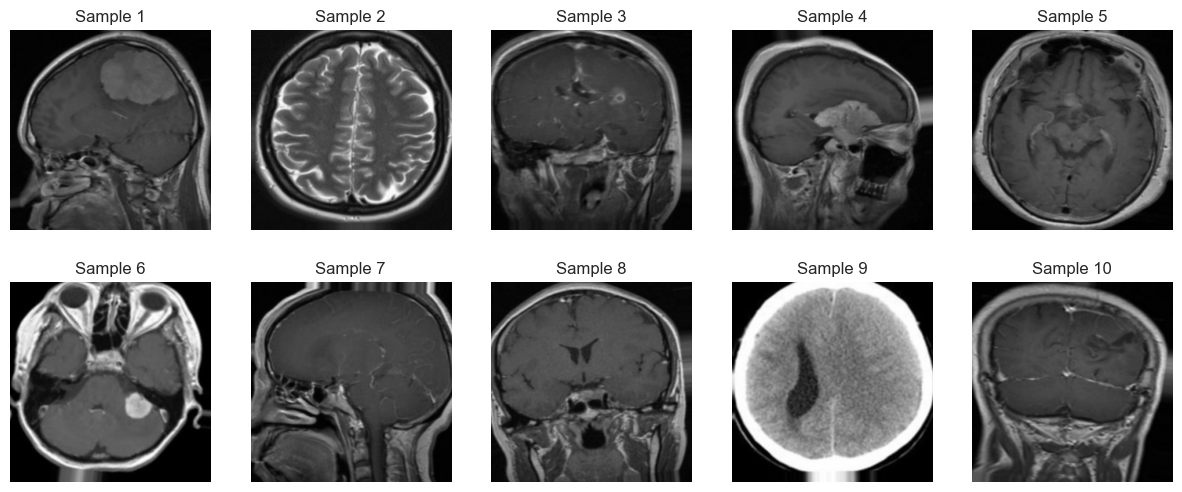

In [69]:
# display 10 augmented images from X_train
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(10):
    img = X_train_augmented[i]
    row = i // 5
    col = i % 5
    ax[row, col].imshow(img)
    ax[row, col].set_title(f"Sample {i+1}")
    ax[row, col].axis("off")

plt.show()

### Model Callbacks

Here we're setting up the necessary tools for optimizing the model's performance during training and evaluation.

- `TensorBoard` A tool provided by TensorFlow allows can help understand the behavior of your model, identify potential problems, and optimize training process.

- `ModelCheckpoint` A callback provided by Keras allows to save the weights of your model during training and to keep track of the best-performing version of your model.

In [74]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [75]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))



## Baseline model

In this step we're going to define baseline model to provide a point of reference for the performance of other more complex models we're going to implement using learning transfer technique, and as well helps to identify if a model is over-fitting or under-fitting the data.

![basic-arch](assets/basic-model-arch.png)

### Network Architecture

A baseline model usually build as simple Convolutional Neural Network (CNN) with a few layers that are commonly used for image processing tasks.

A basic CNN architecture for image classification usually consists of convolutional layers, followed by pooling layers, then one or more fully connected layers (also known as dense layers), and a final output layer.

__Brain Tumor baseline model architecture__

So we decide to build a simple Convolutional Neural Network (CNN) with a few convolutional layers and max pooling layers, followed by a fully connected layer with a sigmoid activation function.

**Our model here designed to take in images of size (256, 256, 1) and output a multi-class classification indicating the type of brain tumor.**

- The model architecture consists of:
    - A convolutional layer with 32 filters of size (7, 7), with stride 1 and no padding.
    - A batch normalization layer to normalize the activations of the previous layer.
    - A ReLU activation layer to introduce non-linearity.
    - A max pooling layer with a pool size of (4, 4), which reduces the size of the feature maps by a factor of 4.
    - Another max pooling layer with a pool size of (4, 4), further reducing the size of the feature maps.
    - A flatten layer to convert the 2D feature maps into a 1D feature vector.
    - A fully connected layer with a sigmoid activation function to generate the final binary classification.

This is a good starting point for a baseline model, and we can explore more advanced architectures or techniques such as `transfer learning` to further improve performance.

We can enhance this baseline model by **adding more convolutional layers, increasing the number of filters in each layer, adding more fully connected layers, and increasing the size of the input images**. However, we need to be careful not to overcomplicate the model, as this can lead to over-fitting and poor performance on new data.

In [16]:
![BrainTumorClassifierModel-arc.png]()

zsh: parse error near `()'


### Model Declaration

In [71]:
def build_sequential_model(input_shape, num_classes):
    """
    Arguments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
        num_classes: An integer representing the number of classes to predict.
    Returns:
        model: A Model object.
    """
    model = Sequential()

    # Add layers to the model
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [72]:
baseline_model = build_sequential_model(IMG_SHAPE, len(labels))
baseline_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 128)     

### Model Compiling

In this for configuring and compiling our model we are using:
- `Adam` optimizer to stochastic gradient descent, to optimize the model's parameters.
- `sparse_categorical_crossentropy` loss function to compute the difference between the predicted and true class labels.
And We're specifying that we want to evaluate the `accuracy` of the model during training.

In [73]:
baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Model Training

In [76]:
start_time = time.time()
baseline_model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
end_time = time.time()
execution_time = (end_time - start_time)

print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 89.6895 - accuracy: 0.5910

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.70.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.70.model/assets


125/125 [==============================] - 30s 225ms/step - loss: 89.6895 - accuracy: 0.5910 - val_loss: 0.7439 - val_accuracy: 0.6984
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.5316 - accuracy: 0.8017

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.77.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.77.model/assets


125/125 [==============================] - 25s 198ms/step - loss: 0.5316 - accuracy: 0.8017 - val_loss: 0.6554 - val_accuracy: 0.7690
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.9105

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.79.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.79.model/assets


125/125 [==============================] - 28s 225ms/step - loss: 0.2594 - accuracy: 0.9105 - val_loss: 0.6837 - val_accuracy: 0.7876
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.9527

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-04-0.81.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-04-0.81.model/assets


125/125 [==============================] - 28s 224ms/step - loss: 0.1323 - accuracy: 0.9527 - val_loss: 0.7343 - val_accuracy: 0.8133
Epoch 5/10
125/125 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9790

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-05-0.80.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-05-0.80.model/assets


125/125 [==============================] - 23s 185ms/step - loss: 0.0602 - accuracy: 0.9790 - val_loss: 0.9778 - val_accuracy: 0.8016
Epoch 6/10
125/125 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9695

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-06-0.77.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-06-0.77.model/assets


125/125 [==============================] - 22s 177ms/step - loss: 0.0917 - accuracy: 0.9695 - val_loss: 0.9410 - val_accuracy: 0.7736
Epoch 7/10
125/125 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.9637

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-07-0.80.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-07-0.80.model/assets


125/125 [==============================] - 23s 182ms/step - loss: 0.1131 - accuracy: 0.9637 - val_loss: 0.9096 - val_accuracy: 0.8022
Epoch 8/10
125/125 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9720

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-08-0.80.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-08-0.80.model/assets


125/125 [==============================] - 22s 177ms/step - loss: 0.1040 - accuracy: 0.9720 - val_loss: 1.0347 - val_accuracy: 0.8022
Epoch 9/10
125/125 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9870

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-09-0.82.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-09-0.82.model/assets


125/125 [==============================] - 23s 182ms/step - loss: 0.0361 - accuracy: 0.9870 - val_loss: 1.0274 - val_accuracy: 0.8203
Epoch 10/10
125/125 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9972

INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-10-0.83.model/assets


INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-10-0.83.model/assets


125/125 [==============================] - 22s 177ms/step - loss: 0.0123 - accuracy: 0.9972 - val_loss: 1.0361 - val_accuracy: 0.8302
Elapsed time: 0:4:10.3


### Model Evaluation

#### Plotting

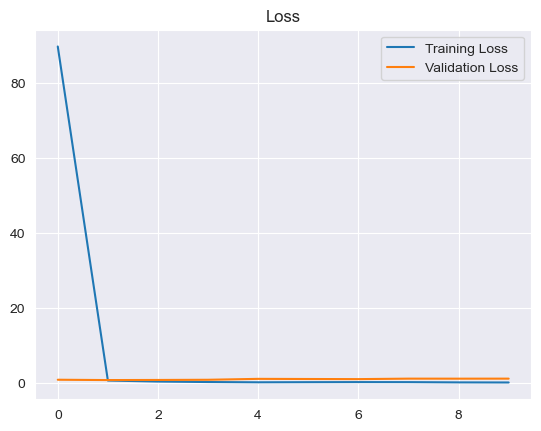

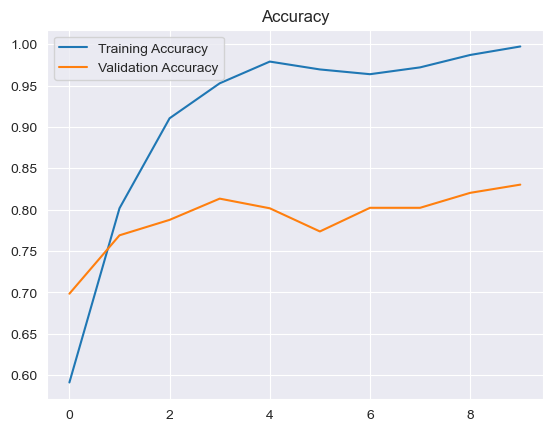

In [78]:
history = baseline_model.history

plot_metrics(history.history)

#### Best Model

In [79]:
best_baseline_model = load_model(filepath=f'{models_path}/cnn-parameters-improvement-10-0.83.model')
best_baseline_model.metrics_names

['loss', 'accuracy']

#### Model Evaluation

In [80]:
baseline_model.evaluate(x=X_val, y=y_val)

54/54 [==============================] - 3s 48ms/step - loss: 1.0361 - accuracy: 0.8302


[1.0361355543136597, 0.8302217125892639]

In [81]:
loss, acc = best_baseline_model.evaluate(x=X_test, y=y_test)

41/41 [==============================] - 3s 55ms/step - loss: 0.9741 - accuracy: 0.8513


In [82]:
best_baseline_model.evaluate(x=X_val, y=y_val)

54/54 [==============================] - 4s 55ms/step - loss: 1.0361 - accuracy: 0.8302


[1.0361355543136597, 0.8302217125892639]

In [92]:
y_test_pred = best_baseline_model.predict(X_test)
y_test_pred_arg = y_test_pred.argmax(axis=1)

41/41 [==============================] - 3s 64ms/step


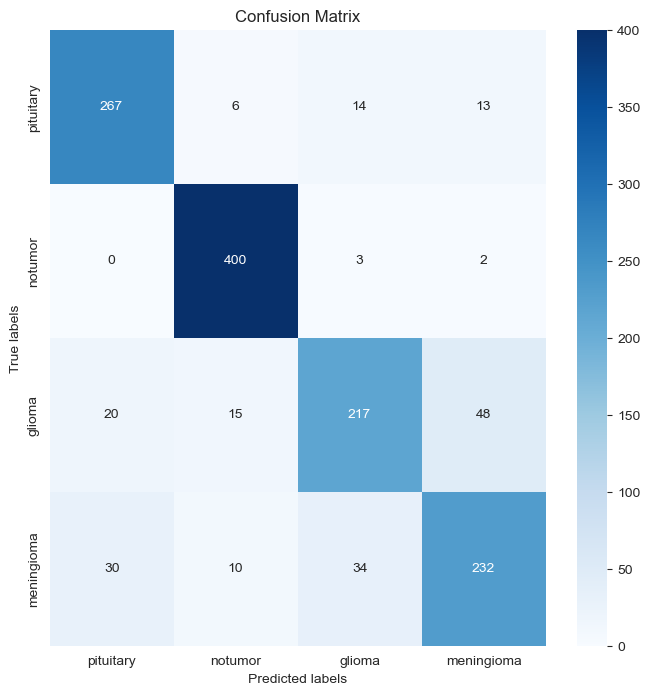

Confusion matrix
None
Classification Report
              precision    recall  f1-score   support

   pituitary       0.84      0.89      0.87       300
     notumor       0.93      0.99      0.96       405
      glioma       0.81      0.72      0.76       300
  meningioma       0.79      0.76      0.77       306

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311

None


In [93]:
co_mat = confusion_matrix(y_test, y_test_pred_arg, labels=labels)

print(co_mat)
print(classification_report(y_test, y_test_pred_arg, labels))

### Final Insights

The results of the baseline model were acceptable, but we decided to explore other combinations to improve the results.
In the first instance, applying another 2-dimensional convolutional operation with 128 filters. This approach improves the accuracy of the model.
After this, we applied a Dropout layer with a rate set to 0.5 or 50%, which means that half of the input units will be randomly set to 0 during each training iteration. (I don’t know if this method is going to improve the accuracy because in the other jupyter notebook it decreased it).
The same Padding on the three 2-dimensional convolutional layers was performed. In that way, we ensure that the spatial dimensions of the input and output tensors are preserved during convolutional operations, and prevent the loss of important spatial information in the network.